## Initial Test

In [1]:
import sys
sys.path.append("../")
import os

current_directory = os.getcwd()
print(current_directory)
from egta.symmetric_game import *
from egta.game import *
from egta.utils.eq_computation import *
from egta.utils.log_multimodal import *
from egta.utils.random_functions import *
from egta.utils.simplex_operations import *
from egta.process_data import *
import matplotlib.pyplot as plt

#test data
#1 for 1 win, 0 for tie, -1 for loss
# 1 -> 2 -> 3 -> 1
'''
RPS Data small test (converges )
'''
rps_data = [ #nash equilibrium is [1/3, 1/3, 1/3] for this data, it is the check data
    [
        ['agent_1', 'ROCK', -1],      
        ['agent_2', 'PAPER', 1],     
        #['agent_3', 'SCISSORS', 0]   
    ],
    
    
    [
        ['agent_1', 'PAPER', 1],      
        #['agent_2', 'ROCK', 1],      
        ['agent_2', 'ROCK', -1] 
    ],
    
    #[
        #['agent_1', 'ROCK', -2],     
        #['agent_2', 'PAPER', 1],    
        #['agent_3', 'PAPER', 1]      
    #],
    
    [
        ['agent_1', 'PAPER', -1],    
        #['agent_2', 'PAPER', -1],    
        ['agent_2', 'SCISSORS', 1]   
    ],
    
    [
        ['agent_1', 'ROCK', 1],      
        ['agent_2', 'SCISSORS', -1] 
        #['agent_3', 'SCISSORS', -1]  
    ],
    [
        ['agent_1', 'SCISSORS', -1],      
        ['agent_2', 'ROCK', 1] 
        #['agent_3', 'SCISSORS', -1]  
    ],
    
    [
        ['agent_1', 'SCISSORS', 1],    
        ['agent_2', 'PAPER', -1]
        #['agent_3', 'SCISSORS', 1]   
    ],
    
    [
        ['agent_1', 'ROCK', 0],     
        ['agent_2', 'ROCK', 0]
        #['agent_3', 'ROCK', 0]
    ],
    
    [
        ['agent_1', 'PAPER', 0],    
        ['agent_2', 'PAPER', 0]
        #['agent_3', 'PAPER', 0]
    ],
    
    [
        ['agent_1', 'SCISSORS', 0], 
        ['agent_2', 'SCISSORS', 0]
        #['agent_3', 'SCISSORS', 0]
    ]
]



/Users/gabesmithline/Desktop/SRG/melo_project/marketsim/egta


Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-1hy1cwkv because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Found 3 repeat profiles in data
Profile (1, 1, 0): Strategy PAPER has 2 payoffs with mean 1.0000
Profile (1, 1, 0): Strategy ROCK has 2 payoffs with mean -1.0000
Profile (1, 0, 1): Strategy PAPER has 2 payoffs with mean -1.0000
Profile (1, 0, 1): Strategy SCISSORS has 2 payoffs with mean 1.0000
Profile (0, 1, 1): Strategy ROCK has 2 payoffs with mean 1.0000
Profile (0, 1, 1): Strategy SCISSORS has 2 payoffs with mean -1.0000
Profile (0, 2, 0): Strategy ROCK has 2 payoffs with mean 0.0000
Profile (2, 0, 0): Strategy PAPER has 2 payoffs with mean 0.0000
Profile (0, 0, 2): Strategy SCISSORS has 2 payoffs with mean 0.0000
Raw payoff table:
Config 1: [PAPER: 1, ROCK: 1] → [PAPER: 1.00, ROCK: -1.00]
Config 2: [PAPER: 1, SCISSORS: 1] → [PAPER: -1.00, SCISSORS: 1.00]
Config 3: [ROCK: 1, SCISSORS: 1] → [ROCK: 1.00, SCISSORS: -1.00]
Config 4: [ROCK: 2] → [ROCK: 0.00]
Config 5: [PAPER: 2] → [PAPER: 0.00]
Config 6: [SCISSORS: 2] → [SCISSORS: 0.00]
2
3
['PAPER', 'ROCK', 'SCISSORS']
tensor([[1., 1.,

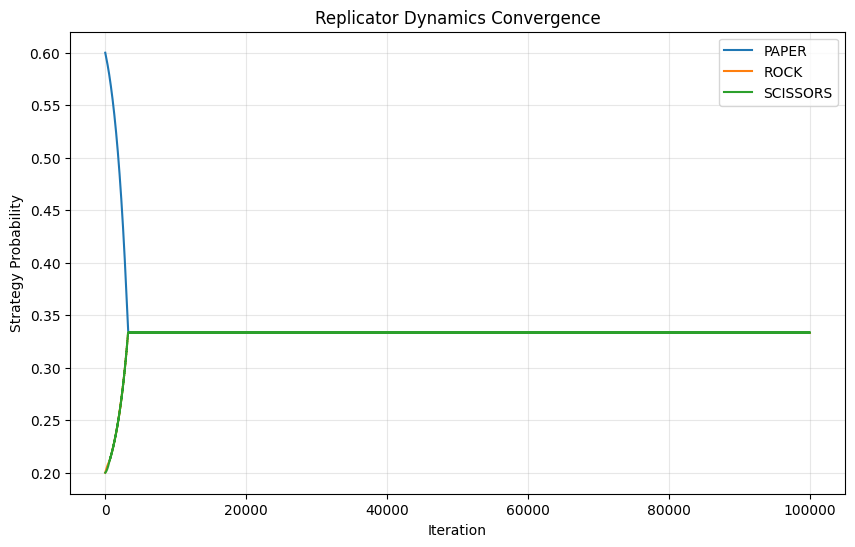

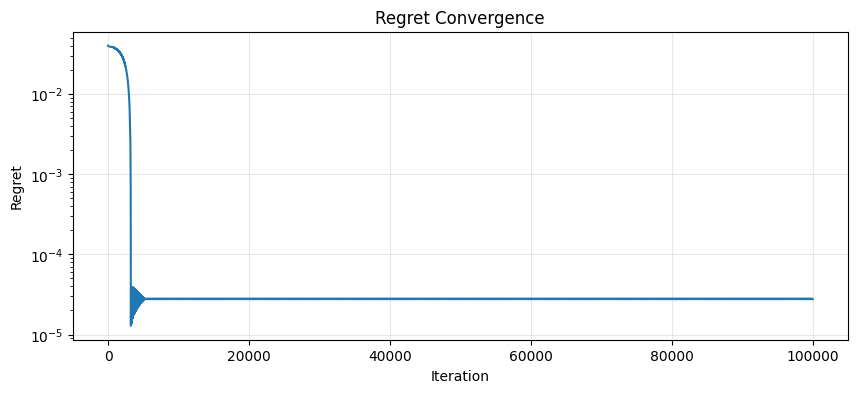

In [4]:
# Create symmetric game from the data
device = "cuda" if torch.cuda.is_available() else "cpu"
rps_game = create_symmetric_game_from_data(rps_data, device=device)
print(rps_game.num_players)
print(rps_game.num_actions)
print(rps_game.strategy_names)
print(rps_game.config_table)
print(rps_game.payoff_table)
print(rps_game.print_full_heuristic_payoff_table())
print(f"Created RPS game with {rps_game.num_players} players and {rps_game.num_actions} strategies")
print(f"Strategy names: {rps_game.strategy_names}")

#find Nash equilibrium using replicator dynamics
iters = 100000

#generate random mixture
random_mixture = torch.rand(rps_game.num_actions, device=rps_game.device)
random_mixture = simplex_normalize(random_mixture)
print(f"Starting random mixture: {random_mixture}")

#run fictitious play
#NOTE: very sensitive to step size, and the initial mixture
#FP works, gradient descent works, rd works
#Not better response does not work?

'''
NOTE:, very sensitive to step size, and the initial mixture, and other hyperparameters

'''
eq_mixture, eq_history = logged_gain_descent(rps_game, [.6, .2, .2], iters=iters, step_size=.001)
print(eq_history)
print("\nNash Equilibrium:")
for i, strat in enumerate(rps_game.strategy_names):
    print(f"{strat}: {eq_mixture[i].item():.4f}")

# Verify this matches the expected [1/3, 1/3, 1/3] distribution
print(f"\nMaximum deviation from uniform: {torch.max(torch.abs(eq_mixture - 1/3)).item():.6f}")

# Calculate regret at the equilibrium
regret = rps_game.regret(eq_mixture)
print(f"Regret at equilibrium: {regret.item():.6f}")

# Plot convergence history
plt.figure(figsize=(10, 6))
for i, strat in enumerate(rps_game.strategy_names):
    plt.plot(eq_history[i, :].cpu().numpy(), label=strat)
plt.xlabel("Iteration")
plt.ylabel("Strategy Probability")
plt.legend()
plt.title("Replicator Dynamics Convergence")
plt.grid(True, alpha=0.3)
plt.show()

# Plot regret over iterations
regrets = torch.zeros(iters+1, device=device)
for i in range(iters+1):
    regrets[i] = rps_game.regret(eq_history[:, i])

plt.figure(figsize=(10, 4))
plt.plot(regrets.cpu().numpy())
plt.xlabel("Iteration")
plt.ylabel("Regret")
plt.title("Regret Convergence")
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()